<a href="https://colab.research.google.com/github/ajitsi/ML_Repo/blob/main/predict_image_custom_hyperparameters_pytoch/05_pytorch_going_modular_exercise_solutions_160824.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Turn the code to get the data (from section 1. Get Data) into a Python script, such as get_data.py

* When you run the script using python get_data.py it should check if the data already exists and skip downloading if it does.
* If the data download is successful, you should be able to access the pizza_steak_sushi images from the data directory.

In [ ]:
%%writefile get_data.py
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")

Overwriting get_data.py


In [ ]:
!python get_data.py

data/pizza_steak_sushi directory exists.
Unzipping pizza, steak, sushi data...


## 2. Use [Python's `argparse` module](https://docs.python.org/3/library/argparse.html) to be able to send the `train.py` custom hyperparameter values for training procedures.
* Add an argument flag for using a different:
  * Training/testing directory
  * Learning rate
  * Batch size
  * Number of epochs to train for
  * Number of hidden units in the TinyVGG model
    * Keep the default values for each of the above arguments as what they already are (as in notebook 05).
* For example, you should be able to run something similar to the following line to train a TinyVGG model with a learning rate of 0.003 and a batch size of 64 for 20 epochs: `python train.py --learning_rate 0.003 batch_size 64 num_epochs 20`.
* **Note:** Since `train.py` leverages the other scripts we created in section 05, such as, `model_builder.py`, `utils.py` and `engine.py`, you'll have to make sure they're available to use too. You can find these in the [`going_modular` folder on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular/going_modular).

In [ ]:
%%writefile data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.
  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.
  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Overwriting data_setup.py


In [ ]:
%%writefile engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.
    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).
    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:
    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.
    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.
    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:
    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.
    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.
    Calculates, prints and stores evaluation metrics throughout.
    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

Overwriting engine.py


In [ ]:
%%writefile model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""
import torch
from torch import nn

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.
    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/
    Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifier(self.block_2(self.block_1(x))) # <- leverage the benefits of operator fusion

Overwriting model_builder.py


In [ ]:
%%writefile utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.
    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.
    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

Overwriting utils.py


In [ ]:
%%writefile train.py
"""
Trains a Pytorch image classification model using device agonstic code
"""

import os
import argparse

import torch

from torchvision import transforms

import data_setup, engine, model_builder, utils

# Create a parser
parser = argparse.ArgumentParser(description="Get some hyperparameters.")


# Get an arg for num_epochs
parser.add_argument("--num_epochs",
                      default=10,
                      type=int,
                      help="the number of epochs to train for")

# Get an arg for batch_size
parser.add_argument("--batch_size",
                    default=32,
                    type=int,
                    help="number of samples per batch")

# Get an arg for hidden_units
parser.add_argument("--hidden_units",
                    default=10,
                    type=int,
                    help="number of hidden units in hidden layers")

# Get an arg for learning_rate
parser.add_argument("--learning_rate",
                    default=0.001,
                    type=float,
                    help="learning rate to use for model")

# Create an arg for training directory
parser.add_argument("--train_dir",
                    default="data/pizza_steak_sushi/train",
                    type=str,
                    help="directory file path to training data in standard image classification format")

# Create an arg for test directory
parser.add_argument("--test_dir",
                    default="data/pizza_steak_sushi/test",
                    type=str,
                    help="directory file path to testing data in standard umage classification format")


# Get our arguments from the parser
args = parser.parse_args()

# Setup hyperparameters
NUM_EPOCHS = args.num_epochs
BATCH_SIZE= args.batch_size
HIDDEN_UNITS= args.hidden_units
LEARNING_RATE = args.learning_rate

print(f"[INFO] Training a model for {NUM_EPOCHS} epochs with batch size {BATCH_SIZE} using {HIDDEN_UNITS} hidden units and a learning rate of {LEARNING_RATE}")

# Setup directories
train_dir = args.train_dir
test_dir = args.test_dir

print(f"[INFO] Training data file: {train_dir}")
print(f"[INFO] Testing data file: {test_dir}")

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model with help from model_builder.py
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_going_modular_script_mode_tinyvgg_model.pth")




Overwriting train.py


In [ ]:
!python train.py --num_epochs 5 --batch_size 128 --hidden_units 128 --learning_rate 0.0003

[INFO] Training a model for 5 epochs with batch size 128 using 128 hidden units and a learning rate of 0.0003
[INFO] Training data file: data/pizza_steak_sushi/train
[INFO] Testing data file: data/pizza_steak_sushi/test
  0% 0/5 [00:00<?, ?it/s]Epoch: 1 | train_loss: 1.0973 | train_acc: 0.3537 | test_loss: 1.0925 | test_acc: 0.3333
 20% 1/5 [00:31<02:04, 31.10s/it]Epoch: 2 | train_loss: 1.1068 | train_acc: 0.3309 | test_loss: 1.0798 | test_acc: 0.3333
 40% 2/5 [00:59<01:28, 29.38s/it]Epoch: 3 | train_loss: 1.0718 | train_acc: 0.4477 | test_loss: 1.0764 | test_acc: 0.4800
 60% 3/5 [01:27<00:57, 28.73s/it]Epoch: 4 | train_loss: 1.0612 | train_acc: 0.4677 | test_loss: 1.0503 | test_acc: 0.4667
 80% 4/5 [01:55<00:28, 28.53s/it]Epoch: 5 | train_loss: 1.0206 | train_acc: 0.4949 | test_loss: 1.0090 | test_acc: 0.4800
100% 5/5 [02:24<00:00, 28.96s/it]
[INFO] Saving model to: models/05_going_modular_script_mode_tinyvgg_model.pth


In [ ]:
%%writefile predict.py
import torch
import torchvision
import argparse

import model_builder

# Creating a parser
parser = argparse.ArgumentParser()

# Get an image path
parser.add_argument("--image",
                    help="target image filepath to predict on")

# Get a model path
parser.add_argument("--model_path",
                    default="models/05_going_modular_script_mode_tinyvgg_model.pth",
                    type=str,
                    help="target model to use for prediction filepath")

args = parser.parse_args()

# Setup class names
class_names = ["pizza", "steak", "sushi"]

# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Get the image path
IMG_PATH = args.image
print(f"[INFO] Predicting on {IMG_PATH}")

# Function to load in the model
def load_model(filepath=args.model_path):
  # Need to use same hypermeter as saved model
  model = model_builder.TinyVGG(
      input_shape=3,
      hidden_units=128,
      output_shape=3
  ).to(device)

  print(f"[INFO] loading in model from: {filepath}")
  model.load_state_dict(torch.load(filepath))

  return model

# Function to load in model + predict on select image
def predict_on_image(image_path=IMG_PATH, filepath=args.model_path):
  # Load the model
  model = load_model(filepath)

  # Load in the image and turn it into torch.float32 (same type as model)
  image = torchvision.io.read_image(str(IMG_PATH)).type(torch.float32)

  # Preprocess the image to get it between 0 and 1
  image = image / 255.

  # Resize the image to be same size as the model
  transform = torchvision.transforms.Resize((64,64))
  image = transform(image)

  # Predict on image
  model.eval()
  with torch.inference_mode():
    # Put image to target device
    image = image.to(device)

    # Get pred logits
    pred_logits = model(image.unsqueeze(dim=0))

    # Get pred probs
    pred_prob = torch.softmax(pred_logits, dim=1)

    # Get pred labels
    pred_label = torch.argmax(pred_prob, dim=1)
    pred_class_label = class_names[pred_label]

  print(f"[INFO] Pred class: {pred_class_label}, Pred prob: {pred_prob.max():.3f}")

if __name__ == "__main__":
  predict_on_image()

Overwriting predict.py


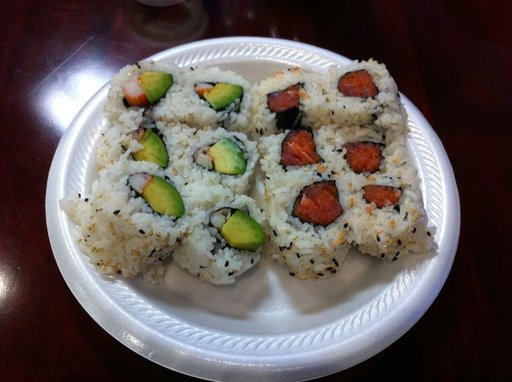

In [ ]:
from PIL import Image
img = Image.open("data/pizza_steak_sushi/test/sushi/175783.jpg")
img

In [ ]:
!python predict.py --image data/pizza_steak_sushi/test/sushi/175783.jpg

[INFO] Predicting on data/pizza_steak_sushi/test/sushi/175783.jpg
[INFO] loading in model from: models/05_going_modular_script_mode_tinyvgg_model.pth
[INFO] Pred class: sushi, Pred prob: 0.425
